# Stock Price Prediction Model

## Table of Contents
- [Introduction](#1)
- [Data Exploration](#2)
- [Data Preparation for Modelling](#3)
- [Machine Learning Model](#4)
- [Backtesting](#5)
- [Adjusting the model](#6)
- [Next steps](#7)

#### Introduction <a class='anchor' id='1'></a>

#### Download the dataset from Yahoo Finance

In [2]:
#Install yahoo finance using pip in Jupyter
!pip install yfinance

In [3]:
#Import libraries
import yfinance as yf
import os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [4]:
#Set variable for Apple stock and entire price history
ticker = 'AAPL'
stock = yf.Ticker(ticker)
stock_hist = stock.history(period='max')

In [5]:
DATA_PATH = f'{ticker.lower()}_data.json'

if os.path.exists(DATA_PATH): #Read from file, if the data is downloaded
    with open(DATA_PATH) as f:
        stock_hist = pd.read_json(DATA_PATH)
else: #Otherwise, download the data
    stock = yf.Ticker(ticker)
    stock_hist = stock.history(period="max")
    stock_hist.to_json(DATA_PATH) #Save file in json format.

#### Data Exploration <a class='anchor' id='2'></a>

In [6]:
stock_hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10917 entries, 1980-12-12 00:00:00-05:00 to 2024-04-03 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          10917 non-null  float64
 1   High          10917 non-null  float64
 2   Low           10917 non-null  float64
 3   Close         10917 non-null  float64
 4   Volume        10917 non-null  int64  
 5   Dividends     10917 non-null  float64
 6   Stock Splits  10917 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 940.4 KB


In [7]:
#Let's look at the first 5 rows of the dataset
stock_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099192,0.099623,0.099192,0.099192,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094448,0.094448,0.094017,0.094017,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.087548,0.087548,0.087116,0.087116,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.089273,0.089704,0.089273,0.089273,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.091861,0.092292,0.091861,0.091861,73449600,0.0,0.0


In [8]:
stock_hist.tail(5) #And last 5 rows

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-27 00:00:00-04:00,170.410004,173.600006,170.110001,173.309998,60273300,0.0,0.0
2024-03-28 00:00:00-04:00,171.750000,172.229996,170.509995,171.479996,65672700,0.0,0.0
2024-04-01 00:00:00-04:00,171.190002,171.250000,169.479996,170.029999,46240500,0.0,0.0
2024-04-02 00:00:00-04:00,169.080002,169.339996,168.229996,168.839996,49258300,0.0,0.0
2024-04-03 00:00:00-04:00,168.750000,170.679993,168.589996,170.270004,27118726,0.0,0.0


Text(0, 0.5, 'Stock Price')

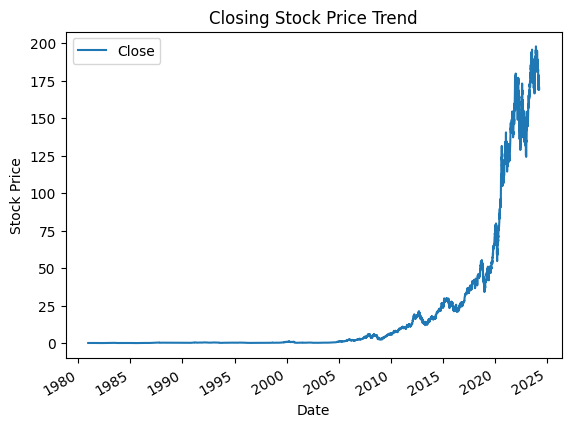

In [9]:
#Visualize the closing stock price trend
stock_hist.plot.line(y='Close', use_index=True)
plt.title('Closing Stock Price Trend')
plt.ylabel('Stock Price')

#### Data Preparation for Modelling <a class='anchor' id='3'></a>

We will create a Target column for our Machine Learning Training later one.

In [10]:
#Creating a separate dataframe with 'Close' column, then renamed to 'Actual_Close' for clarity
data = stock_hist[['Close']]
data = data.rename(columns = {'Close':'Actual_Close'})

#Create Target column - 1 indicating increase in stock price compared to previous day, 0 indicating decrease
#This is done by using the pandas rolling method for 2 rows and lambda function to compare the row indexed at 1 with row indexed at 0
data['Target'] = stock_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])['Close']
data.head()


,Actual_Close,Target
Date,,
1980-12-12 00:00:00-05:00,0.099192,NaN
1980-12-15 00:00:00-05:00,0.094017,0.0
1980-12-16 00:00:00-05:00,0.087116,0.0
1980-12-17 00:00:00-05:00,0.089273,1.0
1980-12-18 00:00:00-05:00,0.091861,1.0


Now we need to associate the next trading 'Date' with the previous day closing and the associated Target column. The ML Model will learn to associate the previous trading Date 'Close' price with the today's 'Date' 'Target'. If the data is not shifted forward, then the ML Model will associate the current day's Closing price with current day's Target, and it will be predicting today's closing price when we want to predict the next day's (future) price.

In [11]:
#Shifting 'Close' column
stock_prev = stock_hist.copy() #make a copy
stock_prev = stock_prev.shift(1) #shift 1 row forward
stock_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15 00:00:00-05:00,0.099192,0.099623,0.099192,0.099192,469033600.0,0.0,0.0
1980-12-16 00:00:00-05:00,0.094448,0.094448,0.094017,0.094017,175884800.0,0.0,0.0
1980-12-17 00:00:00-05:00,0.087548,0.087548,0.087116,0.087116,105728000.0,0.0,0.0
1980-12-18 00:00:00-05:00,0.089273,0.089704,0.089273,0.089273,86441600.0,0.0,0.0


In [12]:
stock_prev['Dividends'].value_counts() #It looks like the distribution is heavily right skewed. This can cause our randomforestclassifier to be biased towards low dividend values.

Dividends
0.000000    10834
0.001071       21
0.142500        4
0.230000        4
0.220000        4
0.205000        4
0.192500        4
0.182500        4
0.157500        4
0.130000        4
0.117500        4
0.108929        4
0.000982        4
0.000893        4
0.000714        4
0.240000        4
0.094643        3
0.000536        2
Name: count, dtype: int64

In [13]:
stock_prev['Stock Splits'].value_counts() #Heavily skewed here as well. Additionally, stock splits only occurred 5 times and are relatively rare events.

Stock Splits
0.0    10911
2.0        3
7.0        1
4.0        1
Name: count, dtype: int64

In [14]:
#Predictors - variables that will be used in our machine learning to predict our target
predictors = ['Close','Volume','Open','High','Low'] #We won't be using dividends and stock splits in the prediction

In [15]:
#Create Training Set
data = data.join(stock_prev[predictors]).iloc[1:] #we ignore the first row


In [16]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1980-12-15 00:00:00-05:00,0.094017,0.0,0.099192,469033600.0,0.099192,0.099623,0.099192
1980-12-16 00:00:00-05:00,0.087116,0.0,0.094017,175884800.0,0.094448,0.094448,0.094017
1980-12-17 00:00:00-05:00,0.089273,1.0,0.087116,105728000.0,0.087548,0.087548,0.087116
1980-12-18 00:00:00-05:00,0.091861,1.0,0.089273,86441600.0,0.089273,0.089704,0.089273
1980-12-19 00:00:00-05:00,0.097467,1.0,0.091861,73449600.0,0.091861,0.092292,0.091861


#### Machine Learning Model <a class='anchor' id='4'></a>

We use a classification algorithm as we are dealing with a binary classification (0 or 1) issue.

In [17]:
#Create random forest classifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)
#n_estimators: number of individual decision trees, the more trees the more robust but also slower
#min_samples_split: minimum number of samples for decision tree to split on. The lower the number, the slower and prone to overfitting to the data.
#random_state: to assign a state so that re-running the algorithm produces the same result

In [18]:
#Create Train and test sets, then train the model
train = data.iloc[:-100]
test = data.iloc[-100:]


#Important to note that when using time series data that future data should not be used to predict past data
#Therefore, our train data will be all the data excluding the last 100 rows
#Our test data will exclude all the data except the last 100 rows

#In other classification models, the train and test set may be split 80:20 ratio.

#Separate predictors and target
X_train = train[predictors]
Y_train = train['Target']
X_test = test[predictors]
Y_test = test['Target']

In [19]:
#Train model on training data
model.fit(X_train, Y_train)

RandomForestClassifier(min_samples_split=200, random_state=1)

In [20]:
#Measuring precision
prediction = model.predict(X_test)
score = precision_score(Y_test, prediction)
score

0.5116279069767442

Our model precision score is 0.42. A high precision score (closer to 1) indicates that our model has a low False Positive Rate. The opposite (closer to 0) means that there is a high False Positive rate. Recall that True Positive means that our model is correctly predicting the target compared to the actual. A False Positive means that our model is predicing the target to be positive when the actual is negative.

Overall, this means that our model is not very good at the moment!

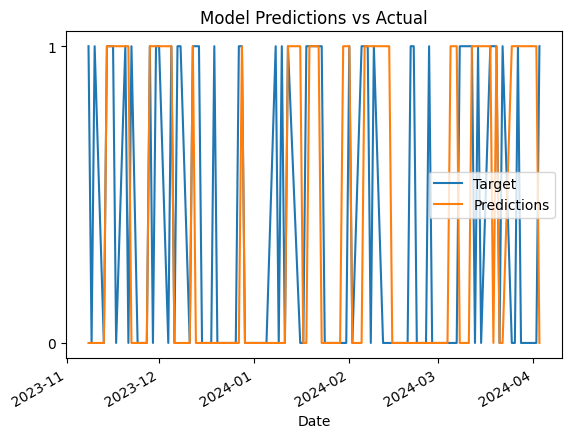

In [21]:
#Visualize predictions vs. actual
prediction = pd.Series(prediction, index=Y_test.index)
combo = pd.concat({'Target':Y_test, 'Predictions':prediction}, axis=1)
combo.plot()
plt.yticks([0,1])
plt.title('Model Predictions vs Actual')
plt.show()

This visual representation shows that our predictions are often incorrect.

#### Backtesting <a class='anchor' id='5'></a>

We will improve our model by changing up how our model can test on more days than the last 100 rows. And we do this by backtesting.

We will need to ensure that our backtesting only uses older data to predict more recent data (as in the real world, you can't predict the past using future data).

In [22]:
#We will do this for 1 iteration first
i = 1000 #rows for training set
step = 750 #next 750 for testing

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()

In [28]:
X_train = train[predictors]
Y_train = train['Target']
X_test = test[predictors]
Y_test = test['Target']

model.fit(X_train, Y_train)

prediction = model.predict(X_test)
score = precision_score(Y_test, prediction)
score

0.4975124378109453

Now let's put this into a loop that iterates over the entire dataset.

In [45]:
predictions = []
for i in range(1000, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    X_train = train[predictors]
    Y_train = train['Target']
    X_test = test[predictors]
    Y_test = test['Target']

    model.fit(X_train, Y_train)

    prediction = model.predict(X_test)

    prediction = pd.Series(prediction, index=Y_test.index)
    combo = pd.concat({'Target':Y_test, 'Predictions':prediction}, axis=1)
    predictions.append(combo)

In [49]:
predictions[0].head()

,Target,Predictions
Date,,
1984-11-27 00:00:00-05:00,1.0,0.0
1984-11-28 00:00:00-05:00,1.0,1.0
1984-11-29 00:00:00-05:00,0.0,0.0
1984-11-30 00:00:00-05:00,0.0,0.0
1984-12-03 00:00:00-05:00,0.0,1.0


In [55]:
#Let's put in into a function
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        X_train = train[predictors]
        Y_train = train['Target']
        X_test = test[predictors]
        Y_test = test['Target']

        model.fit(X_train, Y_train)

        prediction = model.predict(X_test)

        prediction = pd.Series(prediction, index=Y_test.index)
        combo = pd.concat({'Target':Y_test, 'Predictions':prediction}, axis=1)
        predictions.append(combo)
    return pd.concat(predictions)

In [56]:
predictions = backtest(data, model, predictors)

In [57]:
predictions['Predictions'].value_counts()

Predictions
0.0    5810
1.0    4106
Name: count, dtype: int64

In [58]:
predictions['Target'].value_counts()

Target
1.0    4976
0.0    4940
Name: count, dtype: int64

In [60]:
score = precision_score(predictions['Target'], predictions['Predictions'])
score

0.5126643935703848

Looks like our precision is about the same even with backtesting.

#### Adjusting the model <a class='anchor' id='6'></a>

It might be useful to include rolling means into our algorithm predictors, as rolling means can indicate an upward or downward trend.

In [61]:
#Rolling means calculation
weekly_mean = data.rolling(7).mean()['Close']
quarterly_mean = data.rolling(90).mean()['Close']
annual_mean = data.rolling(365).mean()['Close']

In [62]:
#Weekly trend - information on how many days of the week the price went up
weekly_trend = data.shift(1).rolling(7).sum()['Target'] #shift(1) so it doesn't include the current day

In [63]:
#Add columns for rolling means to 'Close' price
data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

In [64]:
#add columns for weekly and quarterly trend in relation to the annual mean
data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

In [65]:
#Add in the weekly trend
data['weekly_trend'] = weekly_trend

In [66]:
#Lastly, we add some predictors for intraday changes in price
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [67]:
#Update our predictor list for another round of modelling
full_predictors = predictors + ['weekly_mean','quarterly_mean','annual_mean','annual_weekly_mean','annual_quarterly_mean','weekly_trend','open_close_ratio','high_close_ratio','low_close_ratio']

In [68]:
#Run the model - we exclude first 365 because these first rows will have null values due to annual_mean
predictions = backtest(data.iloc[365:], model, full_predictors)

In [69]:
score = precision_score(predictions['Target'], predictions['Predictions'])
score

0.5159976730657359

Our model has improved slightly but not by much.

<Axes: xlabel='Date'>

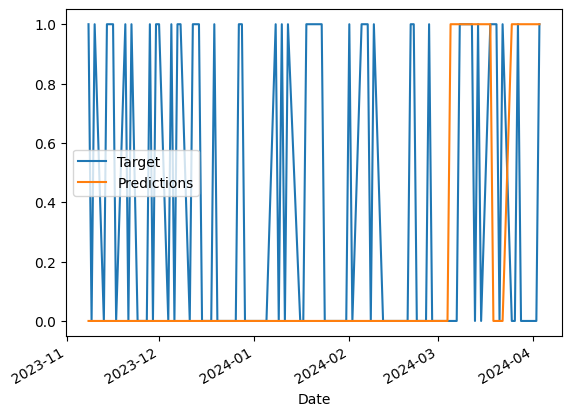

In [70]:
predictions.iloc[-100:].plot()

#### Next steps <a class='anchor' id='7'></a>

Model creation is an iterative process. There are quite a few potential next steps to take to improve our model.

- We can different values for the randomforestclassifer hyperparameters.
- Reduce step size.
- Potentially try a convoluted neural network model if we suspect any sort of temporal pattern that could be better captured compared to randomforest.
- Add in more predictors:
    - Analyst ratings
    - Sector performance
    - Interest rates